#ENGR 8140 - Advanced Deep Learning & Engineering Applications
## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using the CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


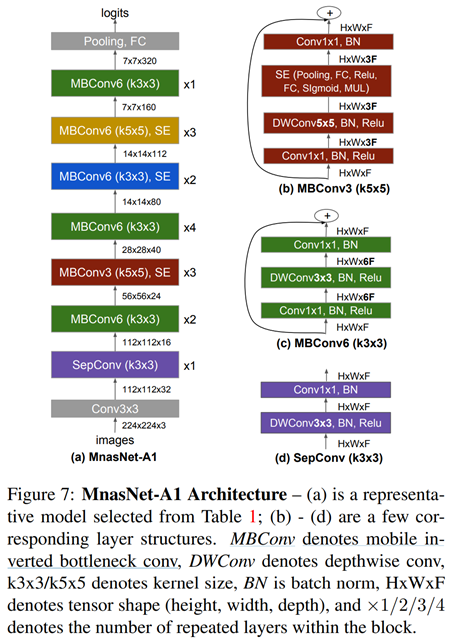

In [1]:
!nvidia-smi
!pip install accelerate -U
!pip show accelerate
!pip install git+https://github.com/huggingface/accelerate
!pip install ptflops
print("pip done")

Sat Feb 24 23:14:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

from torchvision.models import resnet50
from ptflops import get_model_complexity_info

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch.optim as optim

import os

# # Accelerate parts
# from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
# from accelerate.utils import set_seed # reproducability across devices

In [3]:
params_config = [
    {"batch_size": 1024,  "max_epoch": 60,    "learning_rate": 0.01,        "loss_function": nn.CrossEntropyLoss(),    "optimizer": optim.Adam},

]

In [4]:
def get_dataloaders(batch_size):
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    cf10_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    train = CIFAR10(root='./data', train=True, download=True, transform=cf10_transforms)
    test = CIFAR10(root='./data', train=False, download=True, transform=cf10_transforms)
    
    ##################################################################################
    print(train.classes)
    
    torch.manual_seed(42)
    val_size = 5000
    train_size = len(train) - val_size

    ##################################################################################
    
    # 'random_split' is a PyTorch function that randomly splits a dataset into non-overlapping new datasets
    # The lengths of the splits are provided as a list: [train_size, val_size]
    train_ds, val_ds = random_split(train, [train_size, val_size])
    len(train_ds), len(val_ds)
    
    ##################################################################################
    
    # Create a DataLoader for the training dataset
    # shuffle=True will shuffle the dataset before each epoch
    # num_workers=2 will use two subprocesses for data loading
    # pin_memory=True will copy Tensors into CUDA pinned memory before returning them
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, test_loader, train.classes

In [5]:
# # Only execute if necessary

# train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size)
# print(len(classes))

# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(32,32))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
#     break

# # make_grid() arranges images into a grid
# # permute() changes the order of tensor dimensions to fit what imshow expects (height, width, channels)

## Your codes go here:
### (1) Define the model

In [6]:
class SepConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(SepConv, self).__init__()
        # Depthwise convolution followed by BatchNorm and ReLU
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=kernel_size//2, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        # Pointwise convolution followed by BatchNorm without ReLU
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )      

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduced_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_reduce = nn.Conv2d(in_channels, reduced_channels, 1, bias=False)
        self.fc_expand = nn.Conv2d(reduced_channels, in_channels, 1, bias=False)

    def forward(self, x):
        se_weight = self.avg_pool(x)
        se_weight = F.relu(self.fc_reduce(se_weight))
        se_weight = torch.sigmoid(self.fc_expand(se_weight))
        return x * se_weight


class MBConv3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor=3):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        mid_channels = in_channels * expansion_factor
      
        self.expand_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size, stride=stride, padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.se_block = SEBlock(mid_channels, reduced_channels=mid_channels // 4) # Why through 4??
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.expand_conv(x)
        x = self.depthwise_conv(x)
        x = self.se_block(x)
        x = self.project_conv(x)
        return x


class MBConv6(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor=6):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        mid_channels = in_channels * expansion_factor

        self.expand_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size, stride=stride, padding=2, groups=mid_channels, bias=False), # padding=2 to keep the same size ???
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )

        self.project_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.expand_conv(x)
        x = self.depthwise_conv(x)
        x = self.project_conv(x)     
        return x
    
class MBConv6_SE(MBConv6):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor=6):
        super().__init__(in_channels, out_channels, kernel_size, stride, expansion_factor=6)
        self.se_block = SEBlock(out_channels, reduced_channels=out_channels // 4) # Why through 4??

    def forward(self, x):
        x = super().forward(x)
        x = self.se_block(x)
        return x
    
# ----------------------------------------------------------------------------------------------
# class MBConv6(nn.Module):
#     def _init_(self, in_channels, out_channels, kernel_size, stride, expansion_factor=6):
    
# class MBConv3(nn.Module):
#     def _init_(self, in_channels, out_channels, kernel_size, stride, expansion_factor=3):
# ----------------------------------------------------------------------------------------------

# Define the MnasNet-A1 model
class MnasNetA1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initial 3x3 convolution
        self.initial_conv = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # Initial separable convolution
        self.sep_conv = SepConv(32, 16, 3)
        # Sequence of MBConv blocks
        self.blocks = nn.Sequential(
            MBConv6(16, 24, kernel_size=3, stride = 2),
            MBConv6(24, 24, kernel_size=3, stride = 1),
            
            MBConv3(24, 40, kernel_size=3, stride = 2),
            MBConv3(40, 40, kernel_size=3, stride = 1),
            MBConv3(40, 40, kernel_size=3, stride = 1),
            
            MBConv6(40, 80, kernel_size=3, stride = 2),
            MBConv6(80, 80, kernel_size=3, stride = 1),
            MBConv6(80, 80, kernel_size=3, stride = 1),
            MBConv6(80, 80, kernel_size=3, stride = 1),

            MBConv6_SE(80, 112, kernel_size=3, stride = 1),
            MBConv6_SE(112, 112, kernel_size=3, stride = 1),

            MBConv6_SE(112, 160, kernel_size=5, stride = 2),
            MBConv6_SE(160, 160, kernel_size=5, stride = 2),
            MBConv6_SE(160, 160, kernel_size=5, stride = 2),

            MBConv6(160, 320, kernel_size=3, stride = 1),
        )

        # Final separable convolution
        self.final_conv = SepConv(320, 320, 3)
        # Fully connected layer
        self.fc = nn.Linear(320, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.sep_conv(x)
        x = self.blocks(x)
        x = self.final_conv(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

### (2) Train the model using train and val datasets

cuda


100%|██████████| 170498071/170498071 [00:01<00:00, 87525643.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


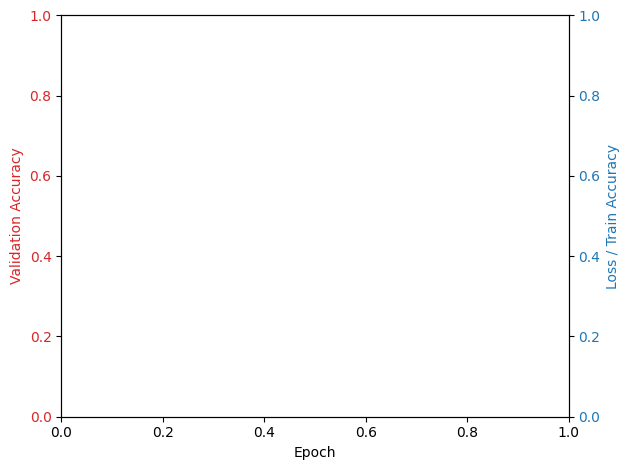

Epoch 1/60: 100%|██████████| 44/44 [00:23<00:00,  1.91batch/s, accuracy=0.189, loss=2.12]


Epoch 1/60, Loss: 0.002068495143784417, Train accuracy: 0.18855555555555556, 'Validation accuracy: 25.94%'


Epoch 2/60: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s, accuracy=0.314, loss=1.7] 


Epoch 2/60, Loss: 0.0016604305426279704, Train accuracy: 0.31406666666666666, 'Validation accuracy: 36.14%'


Epoch 3/60: 100%|██████████| 44/44 [00:18<00:00,  2.33batch/s, accuracy=0.392, loss=1.55]


Epoch 3/60, Loss: 0.001511064386367798, Train accuracy: 0.3917555555555556, 'Validation accuracy: 41.20%'


Epoch 4/60: 100%|██████████| 44/44 [00:19<00:00,  2.31batch/s, accuracy=0.462, loss=1.4] 


Epoch 4/60, Loss: 0.001370881650182936, Train accuracy: 0.46184444444444445, 'Validation accuracy: 48.98%'


Epoch 5/60: 100%|██████████| 44/44 [00:19<00:00,  2.27batch/s, accuracy=0.527, loss=1.27]


Epoch 5/60, Loss: 0.0012395597722795275, Train accuracy: 0.5265333333333333, 'Validation accuracy: 54.08%'


Epoch 6/60: 100%|██████████| 44/44 [00:19<00:00,  2.27batch/s, accuracy=0.57, loss=1.16] 


Epoch 6/60, Loss: 0.0011313332345750597, Train accuracy: 0.5699111111111111, 'Validation accuracy: 58.04%'


Epoch 7/60: 100%|██████████| 44/44 [00:19<00:00,  2.23batch/s, accuracy=0.613, loss=1.06]


Epoch 7/60, Loss: 0.0010407137725088331, Train accuracy: 0.6125555555555555, 'Validation accuracy: 60.02%'


Epoch 8/60: 100%|██████████| 44/44 [00:19<00:00,  2.27batch/s, accuracy=0.639, loss=0.994]


Epoch 8/60, Loss: 0.000972290677494473, Train accuracy: 0.6390666666666667, 'Validation accuracy: 62.48%'


Epoch 9/60: 100%|██████████| 44/44 [00:19<00:00,  2.25batch/s, accuracy=0.659, loss=0.944]


Epoch 9/60, Loss: 0.0009230052696333991, Train accuracy: 0.6594666666666666, 'Validation accuracy: 64.46%'


Epoch 10/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.676, loss=0.899]


Epoch 10/60, Loss: 0.0008789135813713074, Train accuracy: 0.6757555555555556, 'Validation accuracy: 66.08%'


Epoch 11/60: 100%|██████████| 44/44 [00:19<00:00,  2.24batch/s, accuracy=0.693, loss=0.859]


Epoch 11/60, Loss: 0.0008398293203777737, Train accuracy: 0.6931555555555555, 'Validation accuracy: 67.24%'


Epoch 12/60: 100%|██████████| 44/44 [00:19<00:00,  2.23batch/s, accuracy=0.711, loss=0.813]


Epoch 12/60, Loss: 0.0007953545358445909, Train accuracy: 0.7113777777777778, 'Validation accuracy: 67.88%'


Epoch 13/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.724, loss=0.778]


Epoch 13/60, Loss: 0.0007603106353018019, Train accuracy: 0.724, 'Validation accuracy: 69.28%'


Epoch 14/60: 100%|██████████| 44/44 [00:19<00:00,  2.22batch/s, accuracy=0.737, loss=0.745]


Epoch 14/60, Loss: 0.0007280069735315111, Train accuracy: 0.7373111111111111, 'Validation accuracy: 69.58%'


Epoch 15/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.749, loss=0.712]


Epoch 15/60, Loss: 0.0006959173348214891, Train accuracy: 0.7485555555555555, 'Validation accuracy: 70.02%'


Epoch 16/60: 100%|██████████| 44/44 [00:19<00:00,  2.22batch/s, accuracy=0.76, loss=0.678] 


Epoch 16/60, Loss: 0.0006630652109781901, Train accuracy: 0.7597111111111111, 'Validation accuracy: 70.68%'


Epoch 17/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.768, loss=0.66] 


Epoch 17/60, Loss: 0.0006451578179995219, Train accuracy: 0.7675555555555555, 'Validation accuracy: 70.50%'


Epoch 18/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.776, loss=0.633]


Epoch 18/60, Loss: 0.0006191312962108189, Train accuracy: 0.7763333333333333, 'Validation accuracy: 72.18%'


Epoch 19/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=0.783, loss=0.612]


Epoch 19/60, Loss: 0.0005980235603120592, Train accuracy: 0.7831333333333333, 'Validation accuracy: 71.56%'


Epoch 20/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.792, loss=0.593]


Epoch 20/60, Loss: 0.0005801271789603763, Train accuracy: 0.7923111111111111, 'Validation accuracy: 71.90%'


Epoch 21/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.796, loss=0.579]


Epoch 21/60, Loss: 0.0005665927403502994, Train accuracy: 0.7961777777777778, 'Validation accuracy: 73.18%'


Epoch 22/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.802, loss=0.561]


Epoch 22/60, Loss: 0.000548514148261812, Train accuracy: 0.8021777777777778, 'Validation accuracy: 72.34%'


Epoch 23/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.808, loss=0.547]


Epoch 23/60, Loss: 0.0005343556510077583, Train accuracy: 0.8078, 'Validation accuracy: 71.80%'


Epoch 24/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.813, loss=0.531]


Epoch 24/60, Loss: 0.0005195534341865116, Train accuracy: 0.8130444444444445, 'Validation accuracy: 72.48%'


Epoch 25/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.823, loss=0.504]


Epoch 25/60, Loss: 0.0004925508340199789, Train accuracy: 0.8226, 'Validation accuracy: 72.50%'


Epoch 26/60: 100%|██████████| 44/44 [00:20<00:00,  2.17batch/s, accuracy=0.827, loss=0.491]


Epoch 26/60, Loss: 0.0004800988641050127, Train accuracy: 0.8274444444444444, 'Validation accuracy: 73.26%'


Epoch 27/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.831, loss=0.484]


Epoch 27/60, Loss: 0.0004729906426535712, Train accuracy: 0.8307777777777777, 'Validation accuracy: 72.76%'


Epoch 28/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.838, loss=0.465]


Epoch 28/60, Loss: 0.00045450678401523167, Train accuracy: 0.8375777777777778, 'Validation accuracy: 73.62%'


Epoch 29/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.842, loss=0.451]


Epoch 29/60, Loss: 0.0004410484611988068, Train accuracy: 0.8421555555555555, 'Validation accuracy: 72.54%'


Epoch 30/60: 100%|██████████| 44/44 [00:20<00:00,  2.15batch/s, accuracy=0.843, loss=0.446]


Epoch 30/60, Loss: 0.0004364122609297434, Train accuracy: 0.8429333333333333, 'Validation accuracy: 72.44%'


Epoch 31/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.85, loss=0.431] 


Epoch 31/60, Loss: 0.00042141683631473115, Train accuracy: 0.8498666666666667, 'Validation accuracy: 73.46%'


Epoch 32/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=0.852, loss=0.421]


Epoch 32/60, Loss: 0.0004115137510829502, Train accuracy: 0.8520222222222222, 'Validation accuracy: 73.24%'


Epoch 33/60: 100%|██████████| 44/44 [00:20<00:00,  2.17batch/s, accuracy=0.86, loss=0.4]   


Epoch 33/60, Loss: 0.0003914102176825205, Train accuracy: 0.8601777777777778, 'Validation accuracy: 72.36%'


Epoch 34/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.862, loss=0.395]


Epoch 34/60, Loss: 0.000385971243513955, Train accuracy: 0.8619111111111111, 'Validation accuracy: 73.24%'


Epoch 35/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.864, loss=0.387]


Epoch 35/60, Loss: 0.00037878871030277674, Train accuracy: 0.8637555555555556, 'Validation accuracy: 73.20%'


Epoch 36/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=0.871, loss=0.369]


Epoch 36/60, Loss: 0.0003603705664475759, Train accuracy: 0.871, 'Validation accuracy: 72.78%'


Epoch 37/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.874, loss=0.357]


Epoch 37/60, Loss: 0.000349519313706292, Train accuracy: 0.8738222222222222, 'Validation accuracy: 73.48%'


Epoch 38/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.878, loss=0.346]


Epoch 38/60, Loss: 0.0003387435389889611, Train accuracy: 0.8775777777777778, 'Validation accuracy: 73.32%'


Epoch 39/60: 100%|██████████| 44/44 [00:20<00:00,  2.17batch/s, accuracy=0.88, loss=0.342] 


Epoch 39/60, Loss: 0.00033468216922548084, Train accuracy: 0.8804222222222222, 'Validation accuracy: 73.72%'


Epoch 40/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.885, loss=0.329]


Epoch 40/60, Loss: 0.00032160792118973204, Train accuracy: 0.8846444444444445, 'Validation accuracy: 72.84%'


Epoch 41/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.888, loss=0.321]


Epoch 41/60, Loss: 0.00031385986738734776, Train accuracy: 0.8875777777777778, 'Validation accuracy: 72.86%'


Epoch 42/60: 100%|██████████| 44/44 [00:20<00:00,  2.17batch/s, accuracy=0.884, loss=0.33] 


Epoch 42/60, Loss: 0.000322189865509669, Train accuracy: 0.8839777777777778, 'Validation accuracy: 72.54%'


Epoch 43/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=0.889, loss=0.317]


Epoch 43/60, Loss: 0.00030985904733339946, Train accuracy: 0.8885111111111111, 'Validation accuracy: 73.48%'


Epoch 44/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=0.897, loss=0.292]


Epoch 44/60, Loss: 0.000285367422302564, Train accuracy: 0.8970888888888889, 'Validation accuracy: 74.18%'


Epoch 45/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=0.898, loss=0.289]


Epoch 45/60, Loss: 0.0002823136670721902, Train accuracy: 0.8983333333333333, 'Validation accuracy: 73.08%'


Epoch 46/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=0.896, loss=0.297]


Epoch 46/60, Loss: 0.00029039800895584955, Train accuracy: 0.8958888888888888, 'Validation accuracy: 73.58%'


Epoch 47/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.902, loss=0.276]


Epoch 47/60, Loss: 0.0002703316950135761, Train accuracy: 0.9022888888888889, 'Validation accuracy: 73.44%'


Epoch 48/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.903, loss=0.273]


Epoch 48/60, Loss: 0.0002673194391859902, Train accuracy: 0.9032444444444444, 'Validation accuracy: 75.24%'


Epoch 49/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=0.903, loss=0.273]


Epoch 49/60, Loss: 0.00026712303923236, Train accuracy: 0.9031111111111111, 'Validation accuracy: 73.78%'


Epoch 50/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=0.913, loss=0.248]


Epoch 50/60, Loss: 0.0002422378632757399, Train accuracy: 0.9132666666666667, 'Validation accuracy: 73.86%'


Epoch 51/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.914, loss=0.242]


Epoch 51/60, Loss: 0.0002363803744316101, Train accuracy: 0.9143111111111111, 'Validation accuracy: 73.68%'


Epoch 52/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.914, loss=0.244]


Epoch 52/60, Loss: 0.00023836627768145666, Train accuracy: 0.9139777777777778, 'Validation accuracy: 74.16%'


Epoch 53/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.918, loss=0.231]


Epoch 53/60, Loss: 0.0002258841421869066, Train accuracy: 0.9178222222222222, 'Validation accuracy: 74.44%'


Epoch 54/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=0.919, loss=0.229]


Epoch 54/60, Loss: 0.00022369894550906287, Train accuracy: 0.9191777777777778, 'Validation accuracy: 73.76%'


Epoch 55/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.923, loss=0.22] 


Epoch 55/60, Loss: 0.00021494599415196314, Train accuracy: 0.9228444444444445, 'Validation accuracy: 73.98%'


Epoch 56/60: 100%|██████████| 44/44 [00:20<00:00,  2.17batch/s, accuracy=0.926, loss=0.211]


Epoch 56/60, Loss: 0.00020666658646530575, Train accuracy: 0.9255111111111111, 'Validation accuracy: 74.16%'


Epoch 57/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=0.927, loss=0.206]


Epoch 57/60, Loss: 0.0002010080208381017, Train accuracy: 0.9271111111111111, 'Validation accuracy: 72.86%'


Epoch 58/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.924, loss=0.215]


Epoch 58/60, Loss: 0.00021043389439582826, Train accuracy: 0.9239777777777778, 'Validation accuracy: 73.38%'


Epoch 59/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=0.931, loss=0.195]


Epoch 59/60, Loss: 0.00019087578687402936, Train accuracy: 0.9306888888888889, 'Validation accuracy: 73.80%'


Epoch 60/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=0.928, loss=0.2]  


Epoch 60/60, Loss: 0.00019569414191775852, Train accuracy: 0.9283555555555556, 'Validation accuracy: 74.04%'
Finished Training #1


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

counter = 0
for params in params_config:
    
    counter += 1
    batch_size = params["batch_size"]
    max_epoch = params["max_epoch"]
    learning_rate = params["learning_rate"]
    loss_function = params["loss_function"]
    optimizer_function = params["optimizer"]

    # Build the DataLoaders
    train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size)

    # Initialize the model, loss function, optimizer, and scheduler
    model = MnasNetA1(len(classes)).to(device)  # Adjust the number of classes based on your dataset
    criterion = loss_function
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)

    # Very important to use DataParallel to use multiple GPUs
    model = nn.DataParallel(model)

    # Create lists to store metrics
    loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    # Create a second y-axis
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Accuracy', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Loss / Train Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show(block=False)

    # Training loop
    for epoch in range(max_epoch):  # Loop over the dataset multiple times
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Use tqdm to create a progress bar for the training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}", unit="batch") as progress_bar:
            for i, data in enumerate(progress_bar):
                # Get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                ########################################################################################
                # Training the model

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step() 

                ########################################################################################   

                # Update statistics
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix(loss=total_loss / (i+1), accuracy=correct_predictions / total_samples)

        # Validation
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)
        train_accuracy = correct_predictions / total_samples
        train_accuracy_list.append(train_accuracy)

        loss = total_loss / total_samples
        loss_list.append(loss)

        # Optionally, you can print or log other metrics at the end of each epoch
        print(f"Epoch {epoch+1}/{max_epoch}, Loss: {loss}, Train accuracy: {train_accuracy}, 'Validation accuracy: {val_accuracy:.2f}%'")

        # Update the existing plot
        ax1.plot(range(1, epoch+2), val_accuracy_list, color='tab:red')
        ax1.plot(range(1, epoch+2), train_accuracy_list, color='tab:green')
        ax2.plot(range(1, epoch+2), loss_list, color='tab:blue')
        plt.show()
        plt.pause(0.1)  #   Pause for a short period to allow the plot to update
        
    print(f"Finished Training #{counter}")

### (3) Evaluate the model and report performance using the test dataset


Finished Predictions
Accuracy of the network on the test images: 72 %


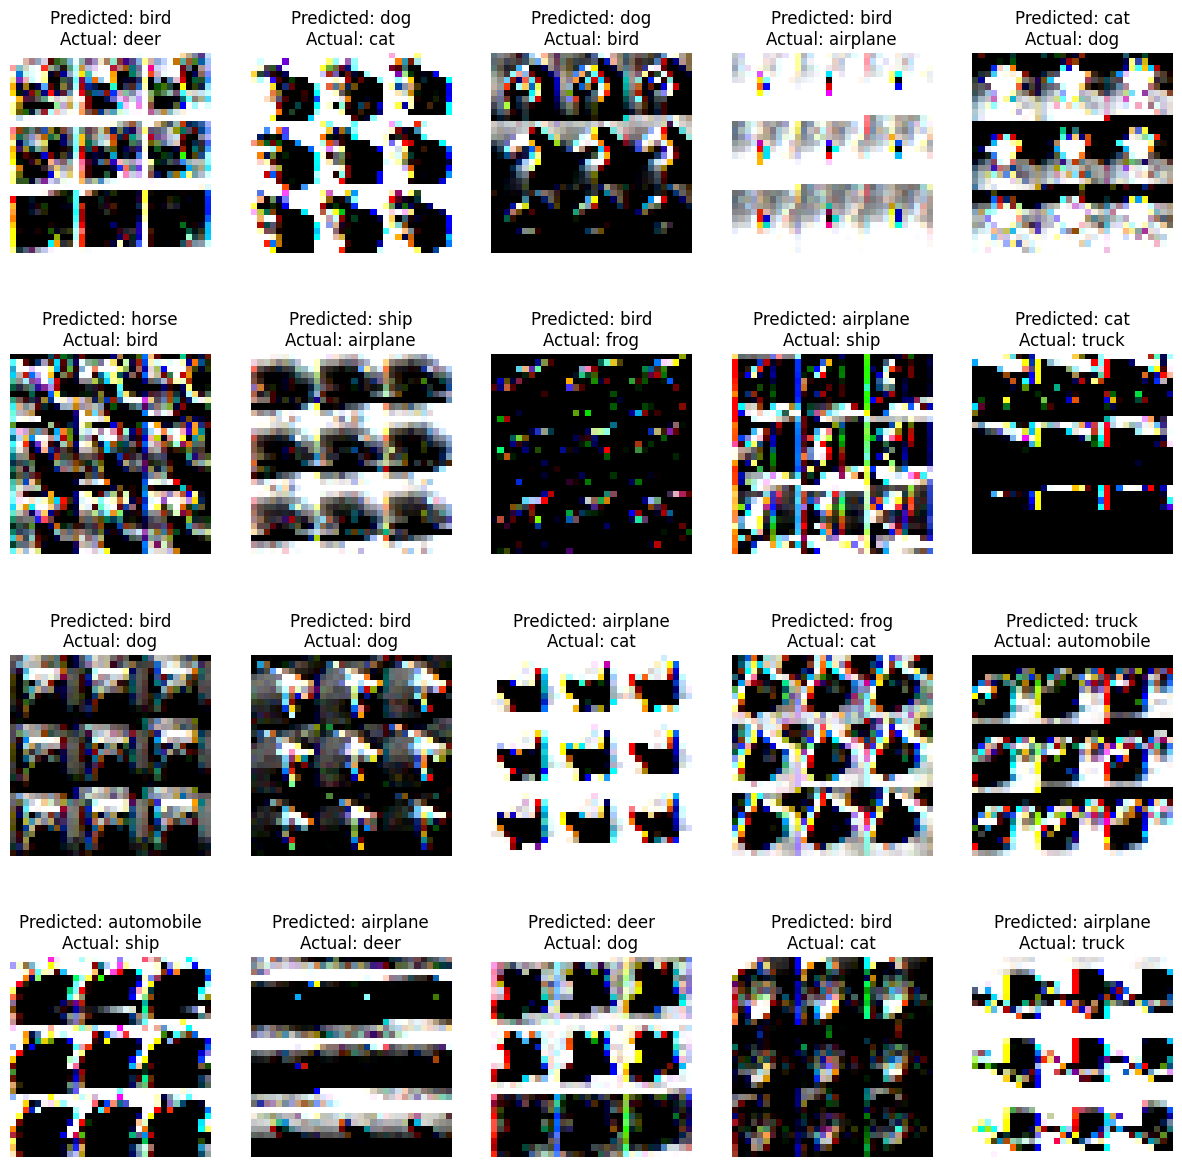

In [8]:
# Switch model to evaluation mode
model.eval()

# Lists to store wrongly predicted images and labels
wrong_images = []
wrong_labels = []
predicted_labels = []
correct = 0
total = 0

# No need to track gradients for prediction, so wrap in no_grad to save memory
with torch.no_grad():
    # Loop over all batches in the test_loader
    for data in test_loader:
        # Move the images and labels to the device (GPU or CPU)
        images, labels = data[0].to(device), data[1].to(device)
        # Pass the images through the model to get the outputs
        outputs = model(images)
        # Get the predicted class for each image by finding the index of the maximum value in the outputs
        _, predicted = torch.max(outputs.data, 1)
        # Increment the total count by the number of images in the current batch
        total += labels.size(0)
        # Increment the correct count by the number of images that were correctly classified
        correct += (predicted == labels).sum().item()
        
        # Compare the predicted labels with the actual labels, resulting in a boolean tensor where True indicates a wrong prediction
        wrong_preds = (predicted != labels)
        # Extend the wrong_images list with the images that were wrongly predicted
        wrong_images.extend(images[wrong_preds].tolist())
        # Extend the wrong_labels list with the actual labels of the images that were wrongly predicted
        wrong_labels.extend(labels[wrong_preds].tolist())
        # Extend the predicted_labels list with the predicted labels of the images that were wrongly predicted
        predicted_labels.extend(predicted[wrong_preds].tolist())

print('Finished Predictions')
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

# Use list comprehension to map the numerical class indices to class names
wrong_labels_txt = [classes[i] for i in wrong_labels]
predicted_labels_txt = [classes[i] for i in predicted_labels]

# Select 20 random indices from the list of wrong predictions
indices = np.random.choice(len(wrong_images), 20)

# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Convert the image data to a 28x28 array
    img = np.array(wrong_images[indices[i]]).reshape(32, 32, 3)
    # Plot the image
    ax.imshow(img)
    # Set the title to the predicted label and the actual label
    ax.set_title(f'Predicted: {predicted_labels_txt[indices[i]]}\nActual: {wrong_labels_txt[indices[i]]}')
    # Remove the axis
    ax.axis('off')

plt.show()

In [9]:
# Use list comprehension to map the numerical class indices to class names
wrong_labels_txt = [classes[i] for i in wrong_labels]
predicted_labels_txt = [classes[i] for i in predicted_labels]

### Histogram

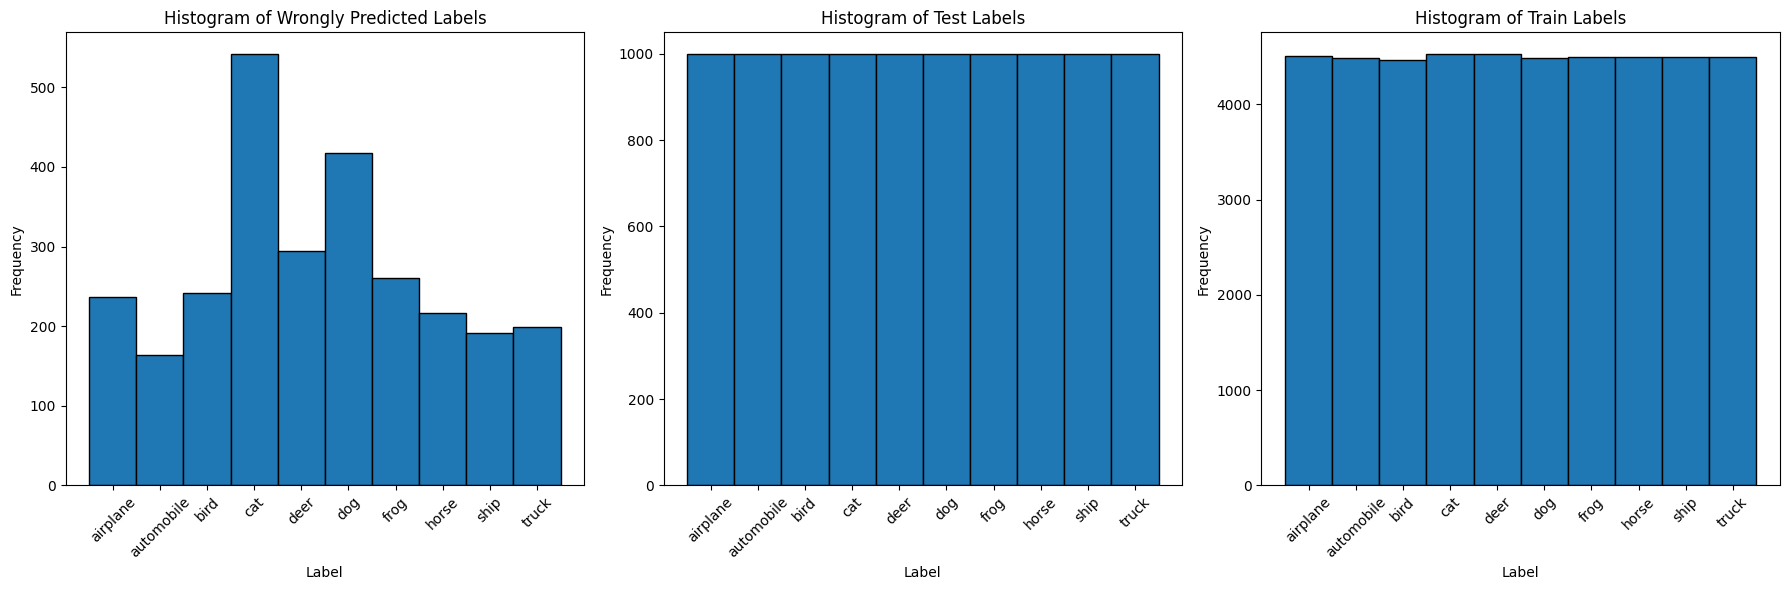

In [10]:
test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.tolist())

train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.tolist())

# Convert the lists of predicted and actual labels to numpy arrays
wrong_labels_np = np.array(wrong_labels)
test_labels_np = np.array(test_labels)
train_labels_np = np.array(train_labels) 

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a histogram of the wrong labels in the first subplot
axes[0].hist(wrong_labels_np, bins=np.arange(wrong_labels_np.min(), wrong_labels_np.max()+2) - 0.5, edgecolor='black')
axes[0].set_title('Histogram of Wrongly Predicted Labels')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(classes, rotation=45)

# Create a histogram of the test labels in the second subplot
axes[1].hist(test_labels_np, bins=np.arange(test_labels_np.min(), test_labels_np.max()+2) - 0.5, edgecolor='black')
axes[1].set_title('Histogram of Test Labels')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(classes, rotation=45)

# Create a histogram of the train labels in the third subplot
axes[2].hist(train_labels_np, bins=np.arange(train_labels_np.min(), train_labels_np.max()+2) - 0.5, edgecolor='black')
axes[2].set_title('Histogram of Train Labels')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Frequency')
axes[2].set_xticks(range(len(classes)))
axes[2].set_xticklabels(classes, rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [1]:
# Create a DataFrame
summary_df = pd.DataFrame({
    "epoch": max_epoch,
    "accuracy": val_accuracy_list,
    "batch_size": batch_size,
    "loss": total_loss,
    "wrong_predictions": len(wrong_images),
})

print(summary_df)

# Save the results to a CSV file
if os.path.isfile('model_performance.csv'):
    summary_df.to_csv('model_performance.csv', index=True, mode='a', header=False)
else:
    summary_df.to_csv('model_performance.csv', index=False, mode='a', header=True)

NameError: name 'pd' is not defined